In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [59]:
df = pd.read_csv("flight_data.csv")

In [7]:
df.info()
# Columns having NULLs: dep_time, dep_delay, arr_time, arr_delay, tailnum, air_time, 
# These variables require cleanup

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          328521 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         328521 non-null float64
arr_time          328063 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         327346 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
tailnum           334264 non-null object
origin            336776 non-null object
dest              336776 non-null object
air_time          327346 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(5)
memory usage: 48.8+ MB


In [9]:
df.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,01-01-2013 05:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,01-01-2013 05:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,01-01-2013 05:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,01-01-2013 05:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,01-01-2013 06:00


In [10]:
# Only dep_delay,arr_delay,air_time,distance are Numerical. 
# Rest are categorical, hence mean etc statistics won't matter for them.
df.loc[:, ["dep_delay","arr_delay","air_time","distance"] ].describe()

,dep_delay,arr_delay,air_time,distance
count,328521.000000,327346.000000,327346.000000,336776.000000
mean,12.639070,6.895377,150.686460,1039.912604
std,40.210061,44.633292,93.688305,733.233033
min,-43.000000,-86.000000,20.000000,17.000000
25%,-5.000000,-17.000000,82.000000,502.000000
50%,-2.000000,-5.000000,129.000000,872.000000
75%,11.000000,14.000000,192.000000,1389.000000
max,1301.000000,1272.000000,695.000000,4983.000000


In [26]:
df["time_hour"].value_counts().shape
df["time_hour"].value_counts()
# Scheduled departure Slot: Date & Hour
# Looks like Maximum flights are scheduled in 8 O'clock slot. 
#       But that may not be true for 1st half of year. Need more analysis. 

(6936,)

13-09-2013 08:00    94
20-09-2013 08:00    94
09-09-2013 08:00    93
23-09-2013 08:00    93
16-09-2013 08:00    93
Name: time_hour, dtype: int64

# Data Clean-Up

## variables require cleanup: dep_time, dep_delay, arr_time, arr_delay, tailnum, air_time, 

## Phase-1:
1. dep_time & dep_delay  : Availability of Any one (clubbed with sched_dep_time) can compute the other
2. arr_time & arr_delay  : Availability of Any one (clubbed with sched_arr_time) can compute the other
3. air_time, dep_time & arr_time  : Any two can compute third 
4. tailnum   : TBD

#### (1) dep_time & dep_delay : Availability of Any one (clubbed with sched_dep_time) can compute the other

 Confirm whether rows have value for at least one variable (out of dep_time & dep_delay)

In [7]:
np.sum( df["dep_time"].isnull() & df["dep_delay"].notnull() )      # 0: So dep_time cannot be filled using dep_delay
np.sum( df["dep_time"].notnull() & df["dep_delay"].isnull() )      # 0: So dep_delay cannot be filled using dep_time

# So "dep_time" & "dep_delay" both are missing simultaneously

0

0

#### (2) arr_time & arr_delay : Availability of Any one (clubbed with sched_arr_time) can compute the other

Confirm whether rows have value for at least one variable (out of arr_time & arr_delay)

In [9]:
np.sum( df["arr_time"].isnull() & df["arr_delay"].notnull() )      #   0: So arr_time cannot be filled using arr_delay
np.sum( df["arr_time"].notnull() & df["arr_delay"].isnull() )      # 717: So 717 arr_delay can be filled using arr_time

0

717

In [42]:
def HHMM_to_Minutes(HHMM):
    return (HHMM//100) * 60 + (HHMM%100)

def HHMM_diff_inMinutes(x1 , x2, ref):
    """ Perform x1-x2    (both are in HHMM format)
        But what-if date changes? (x1-x2) will be big +ve or big -ve.
        Compare (x1-x2) with "ref" to check whether big is really invalid. If so, do correction."""
    x_diff = HHMM_to_Minutes(x1) - HHMM_to_Minutes(x2)
    # If date changes, this will become large -ve or +ve which is not correct. Correct below
    abs(x_diff - ref).hist()    # 23 hrs of deviation found, which is anomaly & indicative of date change
    anomaly_neg = (  (x_diff - ref) < -600  )
    x_diff[anomaly_neg] += 1440

    anomaly_postiv = (    (x_diff - ref) > 600  )
    x_diff[anomaly_postiv] -= 1440

    x_diff.describe()
    return x_diff


count    328063.000000
mean          7.254738
std          45.444558
min        -322.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
dtype: float64

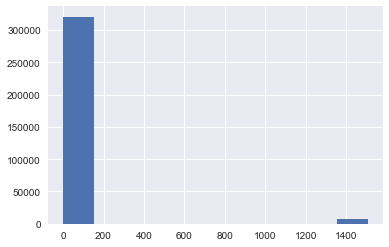

In [43]:
arr_delay_toFILL = HHMM_diff_inMinutes(df.arr_time, df.sched_arr_time, ref=df["dep_delay"])
arr_delay_toFILL.describe()

In [44]:
# Let's fill 717 arr_delay using arr_time
only_arr_time = df.arr_time.notnull() & df.arr_delay.isnull()
df.loc[only_arr_time, "arr_delay"] = arr_delay_toFILL[only_arr_time]

#### (3) air_time, dep_time & arr_time : Any two can compute third



Find rows having any two out of ( arr_time, dep_time, air_time)

In [51]:
np.sum( df["arr_time"].isnull() & df["dep_time"].notnull() & df["air_time"].notnull() )  # 0: So arr_time cannot be filled
np.sum( df["arr_time"].notnull() & df["dep_time"].isnull() & df["air_time"].notnull() )  # 0: So dep_time cannot be filled
np.sum( df["arr_time"].notnull() & df["dep_time"].notnull() & df["air_time"].isnull() )  # 717: So air_time can be filled

0

0

717

In [56]:
air_time_toFILL = HHMM_to_Minutes(df.arr_time) - HHMM_to_Minutes(df.dep_time)
air_time_toFILL.describe()    # -ve found
air_time_toFILL[ air_time_toFILL < 0 ] += 1440
#air_time_toFILL.describe()    # -ve is removed now

count    328063.000000
mean         91.004356
std         253.830350
min       -1401.000000
25%          91.000000
50%         133.000000
75%         172.000000
max         690.000000
dtype: float64

In [60]:
# Fill 717 air_time missing records
both_vars = df.arr_time.notnull() & df.dep_time.notnull() & df.air_time.isnull()
df.loc[both_vars, "air_time"] = air_time_toFILL[both_vars]

df.air_time.describe()

count    328063.000000
mean        151.029805
std          93.966221
min          20.000000
25%          82.000000
50%         130.000000
75%         192.000000
max        1165.000000
Name: air_time, dtype: float64